# Tutorial

In [1]:
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

## Simple Scenario Example

Import the required modules.

In [3]:
from uxsim import *
import pandas as pd

### Scenario Definition

First, we will define the main simulation `W`.
The unit of time is s (seconds) and the unit of length is m.

In [4]:
W = World(
    name="simple_demo",    # Scenario name. Can be blank. Used as the folder name for saving results.
    deltan=5,   # Simulation aggregation unit Δn. Defines how many vehicles are grouped together (i.e., platoon size) for computation. Computation cost is generally inversely proportional to deltan^2.
    tmax=1200,  # Total simulation time (s)
    print_mode=1, save_mode=1, show_mode=1,    # Various options. print_mode determines whether to print information. Usually set to 1, but recommended 0 when running multiple simulations automatically. save_mode determines if visualization results are saved. show_mode determines if visualization results are displayed. It's good to set show_mode=1 on Jupyter Notebook, otherwise recommended 0.
    random_seed=0    # Set the random seed. Specify if you want repeatable experiments. If not, set to None. On Jupyter Notebook, randomness might not always be consistent (requires a fix).
)

The simulation scenario (network structure and demand) is defined.
First, nodes are added, then links are defined to connect the nodes, and finally the traffic demand between the nodes is specified.
In this case, we define a simple Y-shaped merging network.

In [5]:
W.addNode("orig1", 0, 0) #Create a node. Parameters: node name, visualization x-coordinate, visualization y-coordinate
W.addNode("orig2", 0, 2)
W.addNode("merge", 1, 1)
W.addNode("dest", 2, 1)

W.addLink("link1", "orig1", "merge", length=1000, free_flow_speed=20, jam_density=0.2, merge_priority=0.5) # Create a link. Parameters: link name, start node, end node, length, free_flow_speed, jam_density, merge_priority during merging
W.addLink("link2", "orig2", "merge", length=1000, free_flow_speed=20, jam_density=0.2, merge_priority=2)
W.addLink("link3", "merge", "dest", length=1000, free_flow_speed=20, jam_density=0.2)

W.adddemand("orig1", "dest", 0, 1000, 0.4) # Create OD traffic demand. Parameters: origin node, destination node, start time, end time, demand flow rate
W.adddemand("orig2", "dest", 500, 1000, 0.6)

Instead of defining scenarios by hard-code, scenarios can be read from a CSV file prepared in advance, as shown below.
```python
W.load_scenario_from_csv("dat/siouxfalls_nodes.csv", "dat/siouxfalls_links.csv", "dat/siouxfalls_demand.csv")
```

### Simulation Execution

After defining the scenario, you can execute the simulation with `W.exec_simulation()`. This time, the simulation is run to the end. The simulation time, the number of vehicles in the network at that time, their average speed, and the computation time are displayed.

In [6]:
W.exec_simulation()

simulation setting:
 scenario name: simple_demo
 simulation duration:	 1200 s
 number of vehicles:	 700 veh
 total road length:	 3000 m
 time discret. width:	 5 s
 platoon size:		 5 veh
 number of timesteps:	 240
 number of platoons:	 140
 number of links:	 3
 number of nodes:	 4
 setup time:		 0.13 s
simulating...
      time| # of vehicles| ave speed| computation time
       0 s|        0 vehs|   0.0 m/s|     0.00 s
     600 s|      100 vehs|  17.5 m/s|     0.03 s
    1195 s|       25 vehs|  20.0 m/s|     0.06 s
 simulation finished


1

Instead of running the simulation to the end, it is possible to run it halfway and intervene in the simulation.
For example, the following code computes the simulation for 100 seconds at a time and uses the function `hoge` to perform some intervention.

```python
while W.check_simulation_ongoing():
    W.exec_simulation(duration_t=100)
    hoge()
```

### Results

The `W.analyzer` class is responsible for analyzing the results.

A summary of the results can be printed below. Delay ratio is the ratio of delay time to total trip time, with a value close to zero indicating smooth traffic (when the shortest route can be traveled without congestion) and a larger value indicating congestion (when the shortest route is bypassed or congested).

In [7]:
W.analyzer.print_simple_stats()

results:
 average speed:	 13.8 m/s
 number of completed trips:	 675 / 700
 average travel time of trips:	 142.7 s
 average delay of trips:	 42.7 s
 delay ratio:			 0.299


Simulation results can be output to pandas.DataFrame. Note that the value `-1` basically means undefined (e.g., headway when there is no vehicle in front).

In [8]:
#overall
df = W.analyzer.basic_to_pandas()
display(df)

#OD-specific traffic situation
df = W.analyzer.od_to_pandas()
display(df)

#MFD
df = W.analyzer.mfd_to_pandas()
display(df)

#link-level
df = W.analyzer.link_to_pandas()
display(df)

#within link
df = W.analyzer.link_traffic_state_to_pandas()
display(df)

#vehicle-level
df = W.analyzer.vehicles_to_pandas()
display(df)

total_trips  completed_trips  total_travel_time  average_travel_time  \
0          700              675            96325.0           142.703704   

   total_delay  average_delay  
0      28825.0      42.703704

orig  dest  total_trips  completed_trips  free_travel_time  \
0  orig1  dest          400              375             100.0   
1  orig2  dest          300              300             100.0   

   average_travel_time  stddiv_travel_time  
0           168.466667           88.990536  
1           110.500000            4.444097

t  network_k  network_q
0  0   0.006944   0.138889

link  traffic_volume  vehicles_remain  free_travel_time  \
0  link1             400                0              50.0   
1  link2             300                0              50.0   
2  link3             675               25              50.0   

   average_travel_time  stddiv_travel_time  
0           128.625000           81.718425  
1            55.583333            6.129958  
2            52.166667            2.477678

link     t      x  delta_t  delta_x         q         k     v
0    link1     0    0.0      120    100.0  0.375000  0.018750  20.0
1    link1     0  100.0      120    100.0  0.333333  0.016667  20.0
2    link1     0  200.0      120    100.0  0.333333  0.016667  20.0
3    link1     0  300.0      120    100.0  0.333333  0.016667  20.0
4    link1     0  400.0      120    100.0  0.291667  0.014583  20.0
..     ...   ...    ...      ...      ...       ...       ...   ...
295  link3  1080  500.0      120    100.0  0.770833  0.038542  20.0
296  link3  1080  600.0      120    100.0  0.770833  0.038542  20.0
297  link3  1080  700.0      120    100.0  0.760417  0.038021  20.0
298  link3  1080  800.0      120    100.0  0.760417  0.038021  20.0
299  link3  1080  900.0      120    100.0  0.791667  0.039583  20.0

[300 rows x 8 columns]

name  dn   orig  dest     t      link      x      s     v
0       0   5  orig1  dest    15     link1    0.0   -1.0  20.0
1       0   5  orig1  dest    20     link1  100.0   -1.0  20.0
2       0   5  orig1  dest    25     link1  200.0   -1.0  20.0
3       0   5  orig1  dest    30     link1  300.0   -1.0  20.0
4       0   5  orig1  dest    35     link1  400.0   -1.0  20.0
...   ...  ..    ...   ...   ...       ...    ...    ...   ...
4207  139   5  orig2  dest  1100     link3  675.0  225.0  20.0
4208  139   5  orig2  dest  1105     link3  775.0   -1.0  20.0
4209  139   5  orig2  dest  1110     link3  875.0   -1.0  20.0
4210  139   5  orig2  dest  1115     link3  975.0   -1.0  20.0
4211  139   5  orig2  dest  1115  trip_end   -1.0   -1.0  -1.0

[4212 rows x 9 columns]

You can also save the entire results to CSV.

In [9]:
W.analyzer.output_data()

### Visualization of Results

#### Link-level

Time-space diagrams (density and trajectories) of a link can be plotted as follows.
Ones for consecutive links can also be plotted.

 drawing traffic states...


  0%|          | 0/3 [00:00<?, ?it/s]

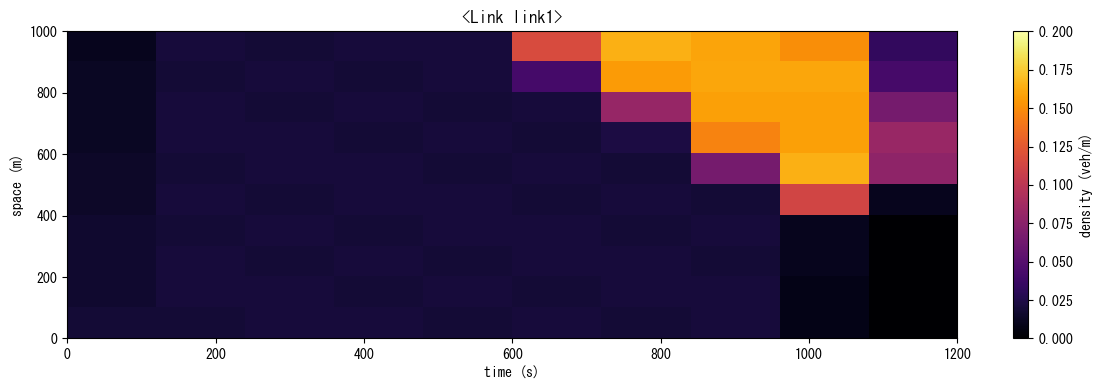

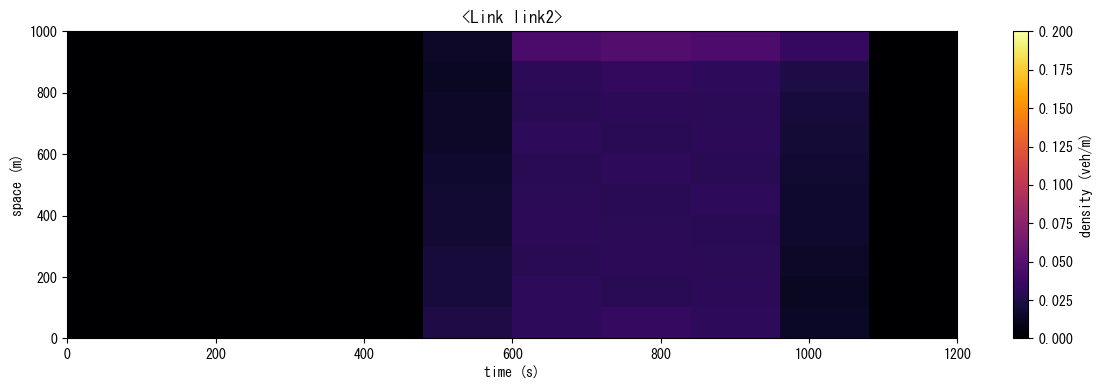

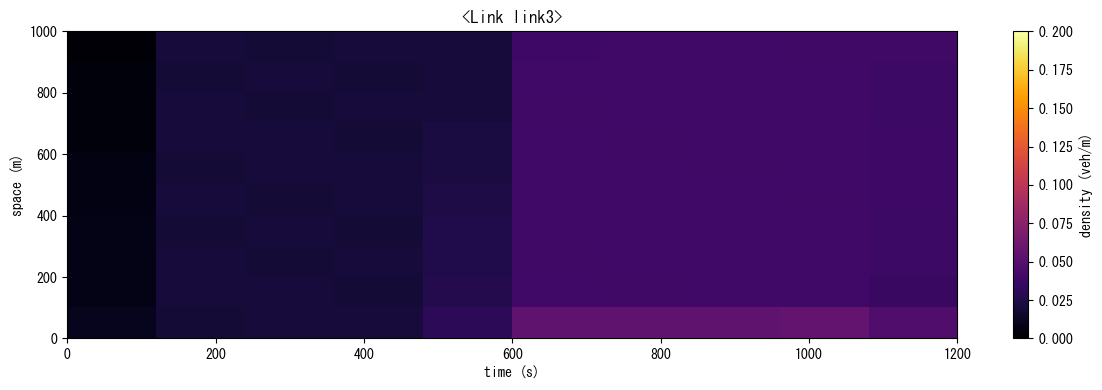

 drawing trajectories...


  0%|          | 0/3 [00:00<?, ?it/s]

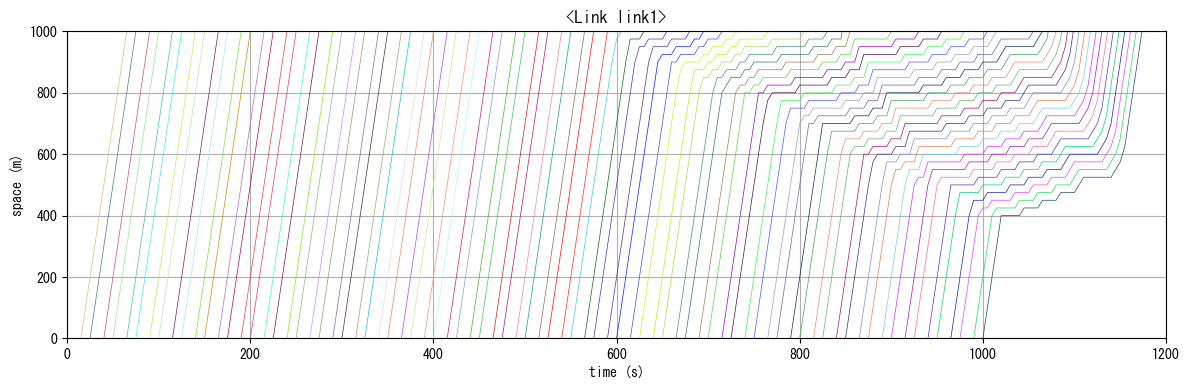

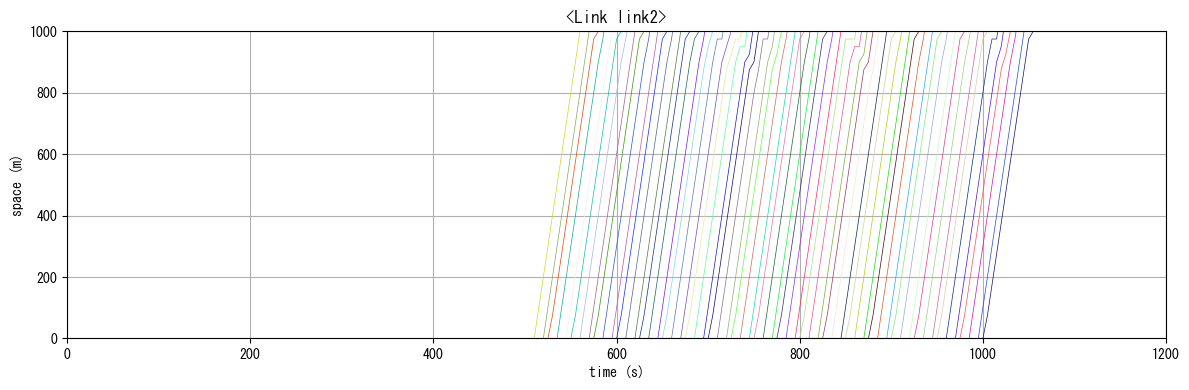

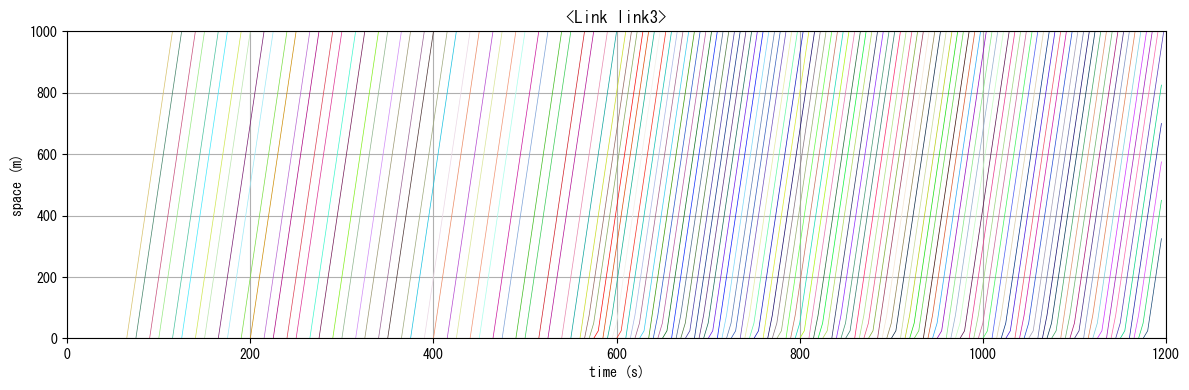

 drawing trajectories in consecutive links...


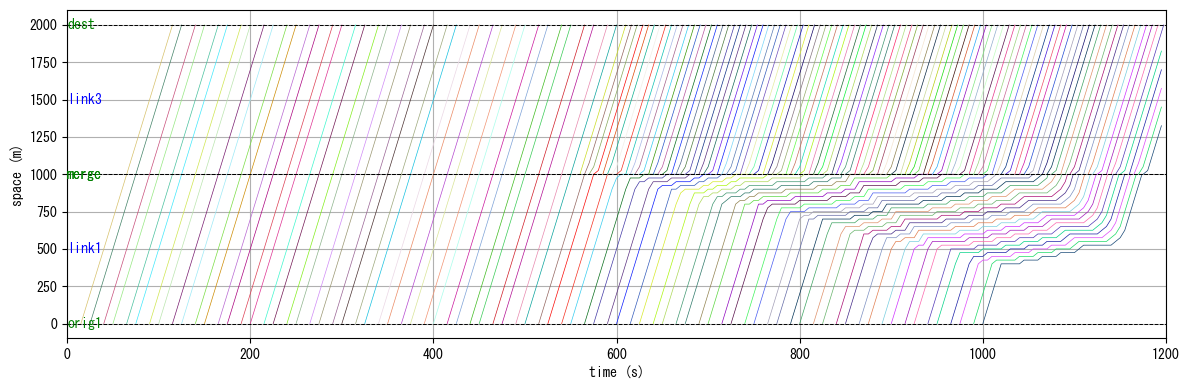

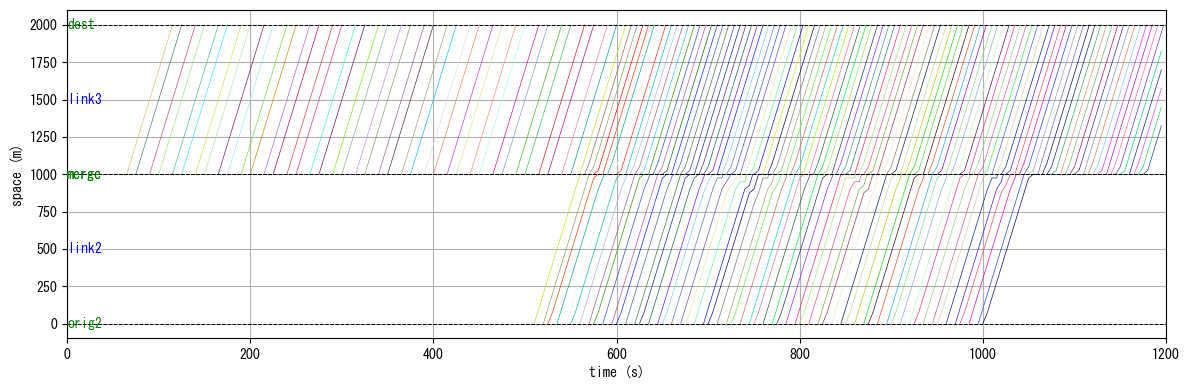

In [10]:
W.analyzer.time_space_diagram_density()
W.analyzer.time_space_diagram_traj()

W.analyzer.time_space_diagram_traj_links([["link1", "link3"], ["link2", "link3"]])

Cumulative curves, actual/instantanious travel times

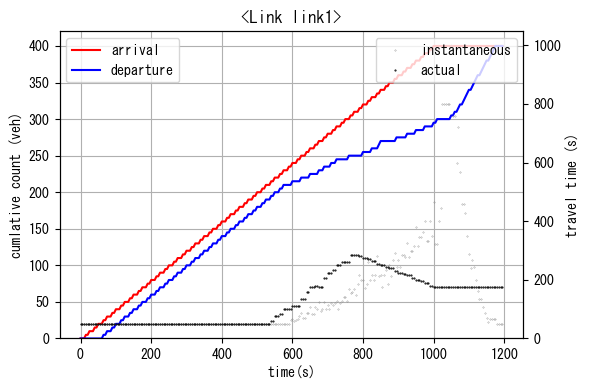

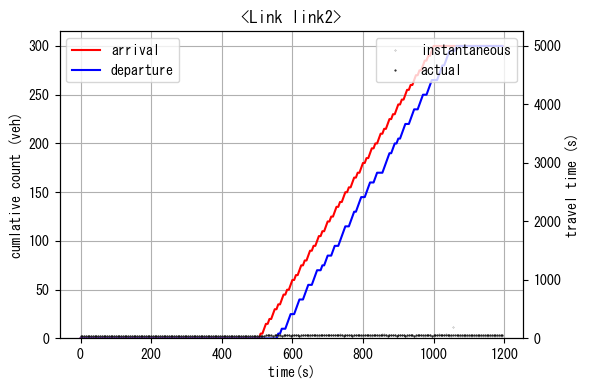

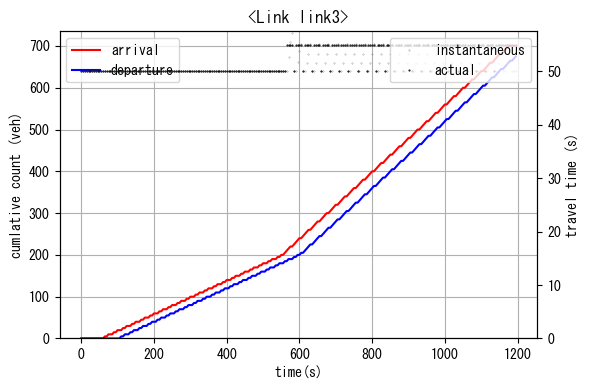

In [11]:
W.analyzer.cumulative_curves()

#### Area/Network-level

MFD

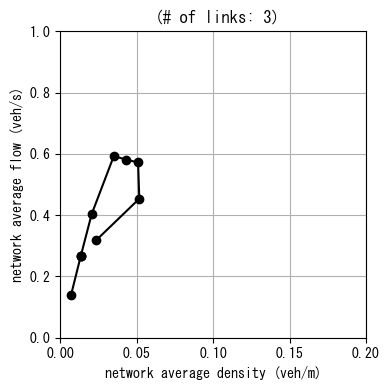

In [12]:
W.analyzer.macroscopic_fundamental_diagram()

Snapshots of network traffic situation

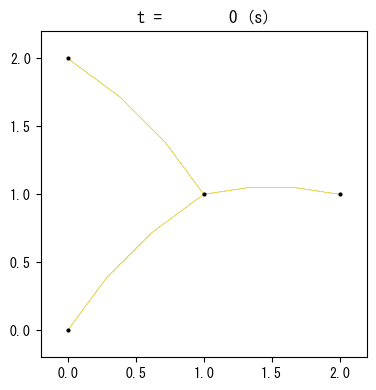

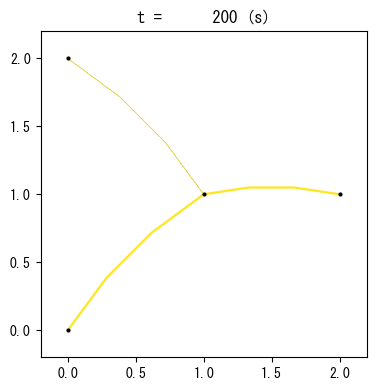

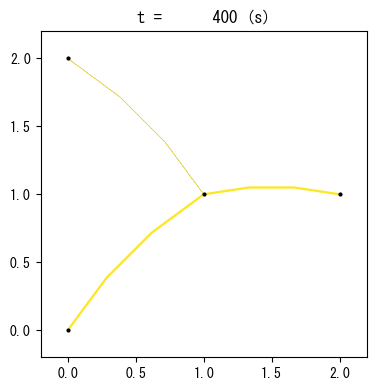

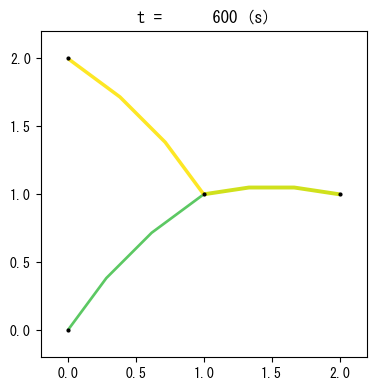

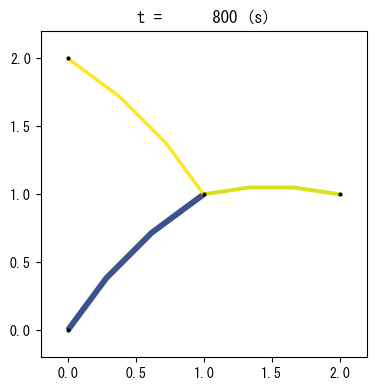

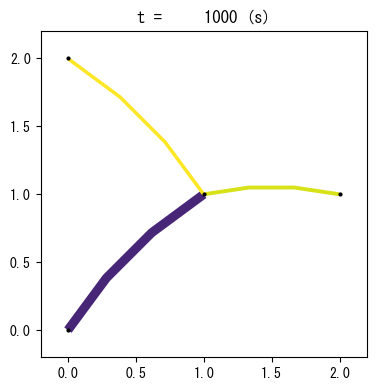

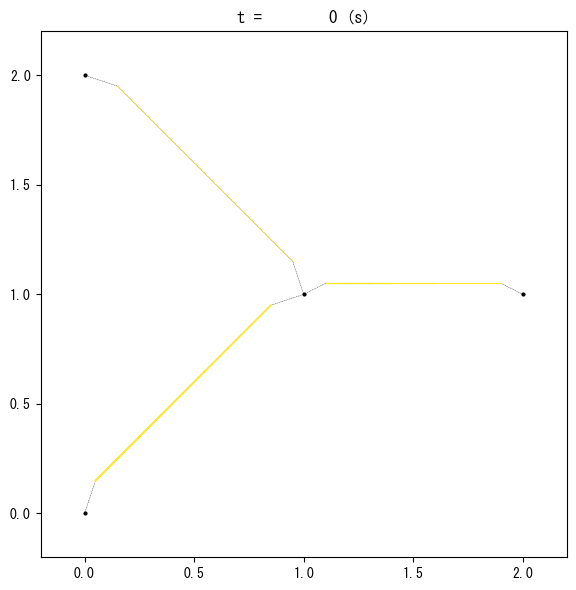

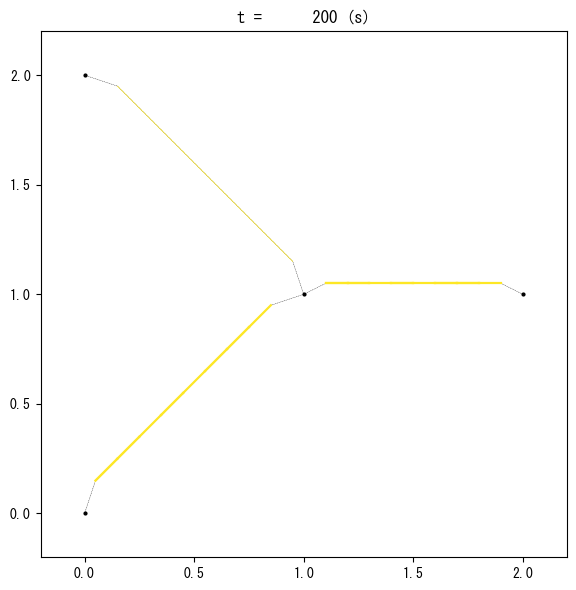

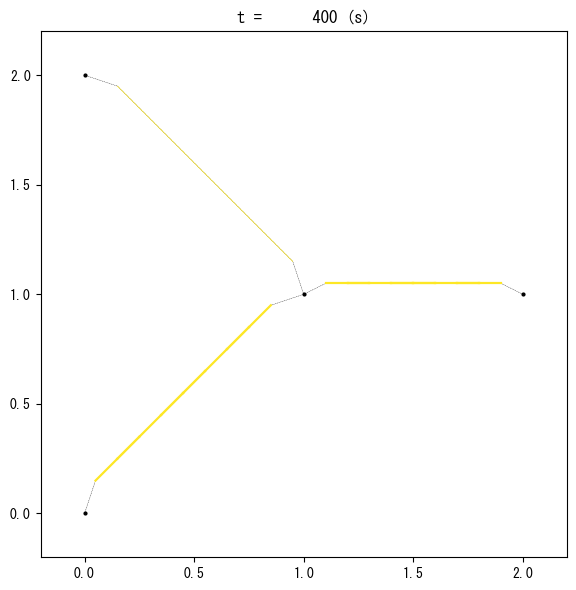

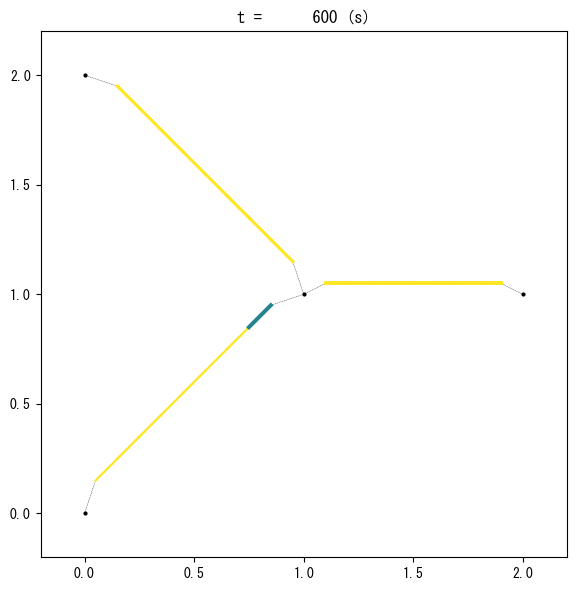

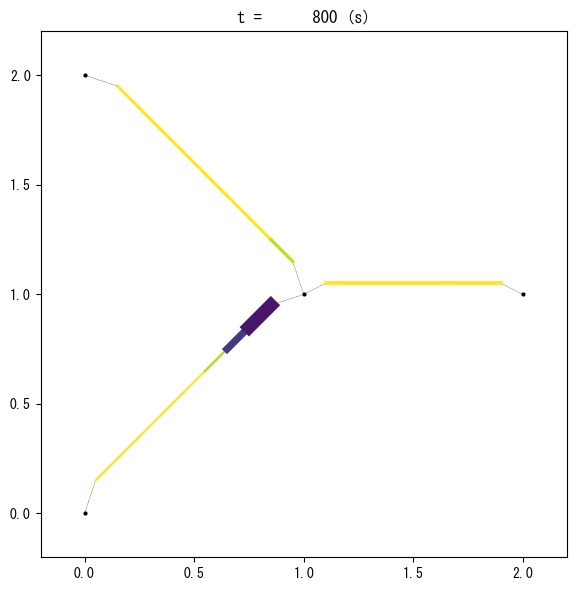

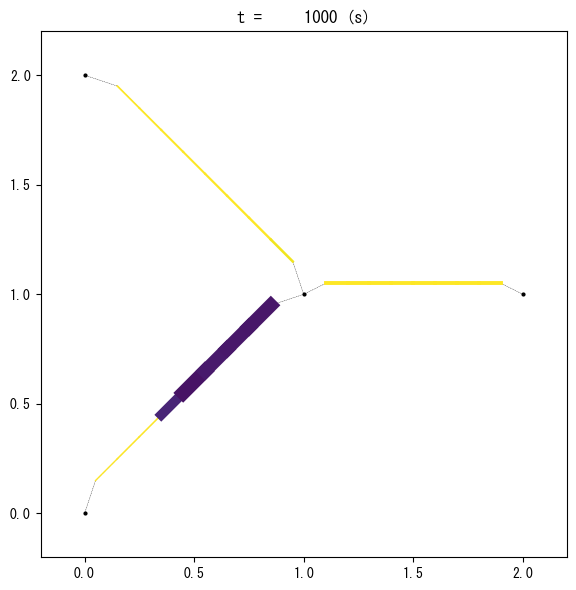

In [13]:
for t in list(range(0,W.TMAX,int(W.TMAX/6))):
    W.analyzer.network(t, detailed=0, network_font_size=0, figsize=(4,4))
for t in list(range(0,W.TMAX,int(W.TMAX/6))):
    W.analyzer.network(t, detailed=1, network_font_size=0)

You can also create a gif animation of the traffic situation of the entire network.
By default, you can visualize the traffic situation per link, the traffic situation per section within a link (not very clear depending on the network geometry), and the movement trajectory of some vehicles.
The thicker the width of the link, the greater the number and density of vehicles, and the darker the color, the lower the speed.
Note that the creation speed for large scenarios is very slow.

 generating animation...


  0%|          | 0/8 [00:00<?, ?it/s]

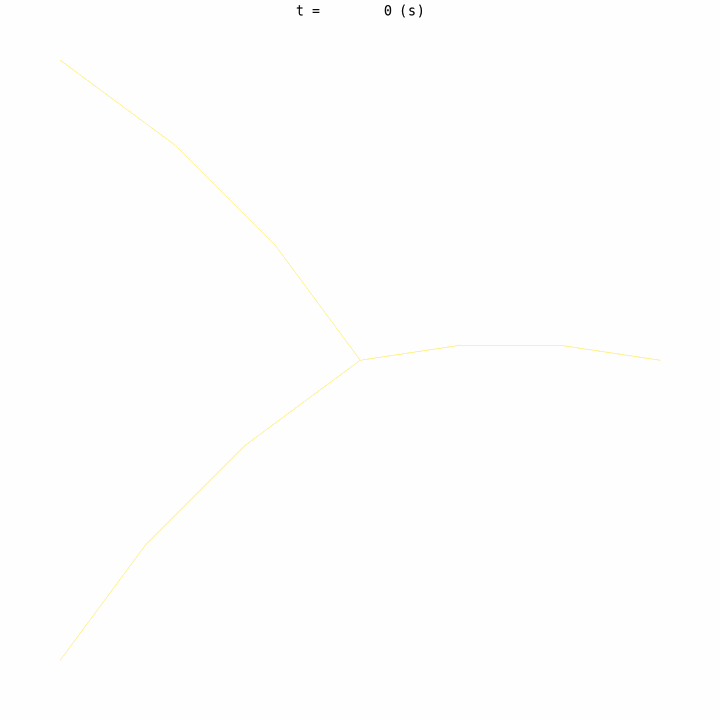

 generating animation...


  0%|          | 0/10 [00:00<?, ?it/s]

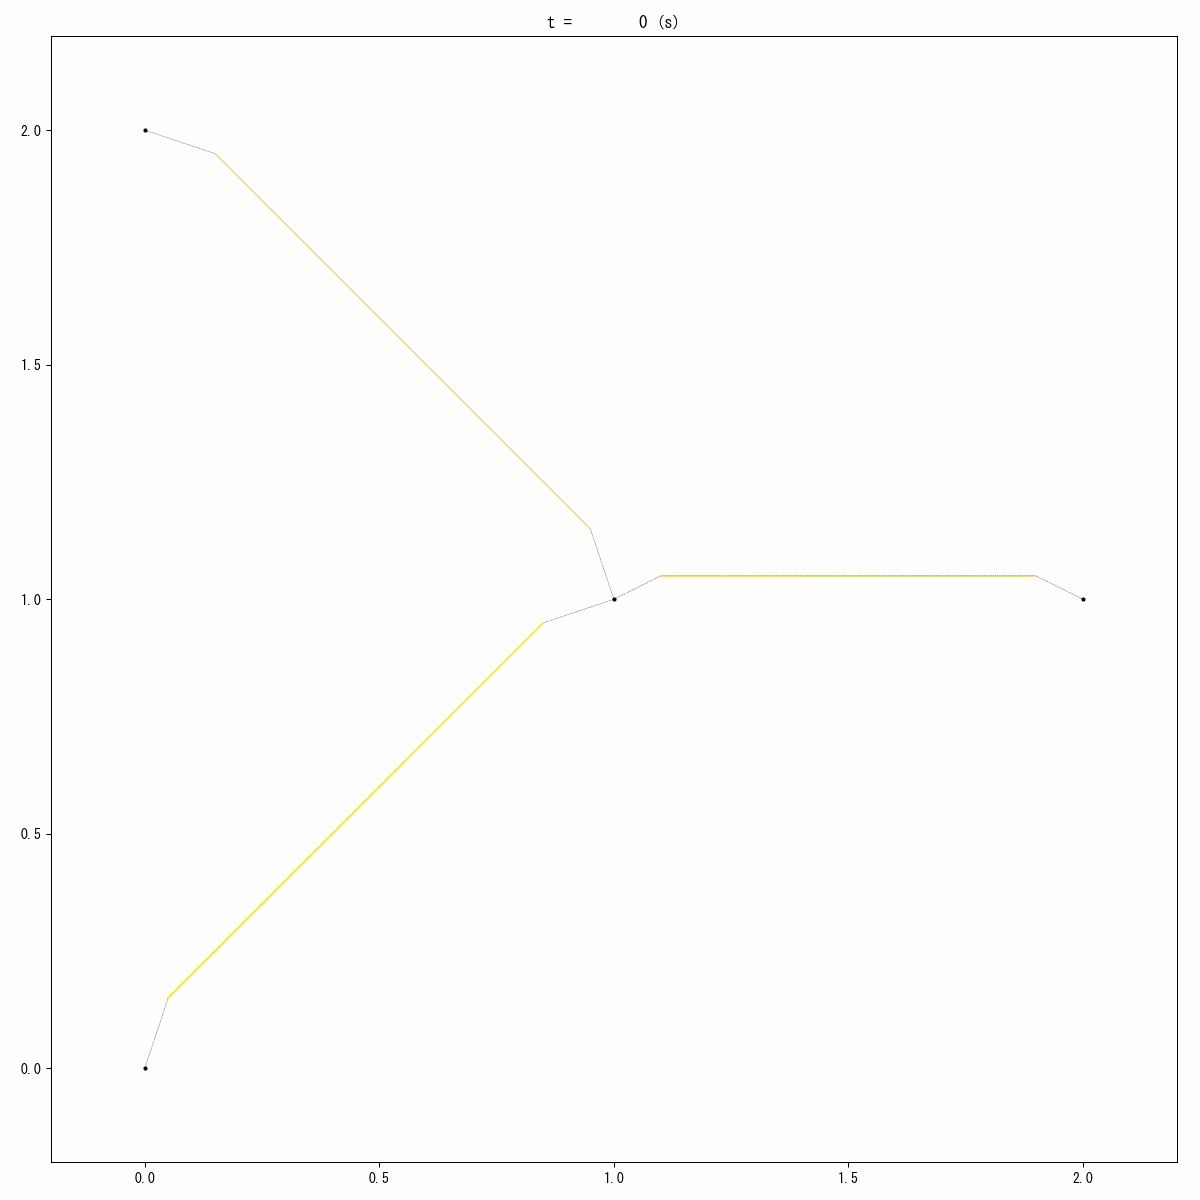

 generating animation...


  0%|          | 0/120 [00:00<?, ?it/s]

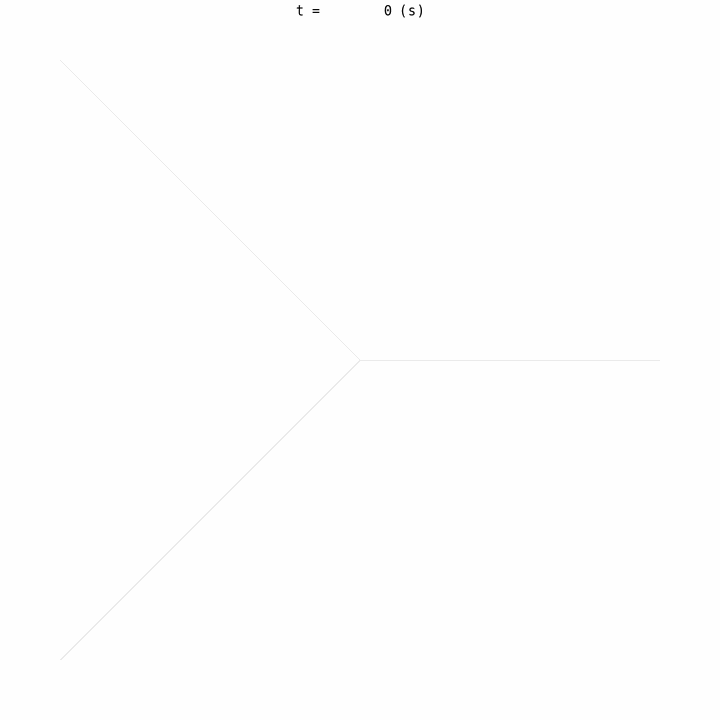

In [14]:
W.analyzer.network_anim(animation_speed_inverse=15, timestep_skip=30, detailed=0, network_font_size=0)
from IPython.display import display, Image
with open("outsimple_demo/anim_network0.gif", "rb") as f:
    display(Image(data=f.read(), format='png'))
    
W.analyzer.network_anim(detailed=1, figsize=(12,12), network_font_size=0)

with open("outsimple_demo/anim_network1.gif", "rb") as f:
    display(Image(data=f.read(), format='png'))

W.analyzer.network_fancy(animation_speed_inverse=15, sample_ratio=0.3, interval=3, trace_length=5, network_font_size=0)

with open("outsimple_demo/anim_network_fancy.gif", "rb") as f:
    display(Image(data=f.read(), format='png'))
    

#### Vehicle-level

The driving log of a single vehicle can also be visualized. The links traveled and the speed at that time.

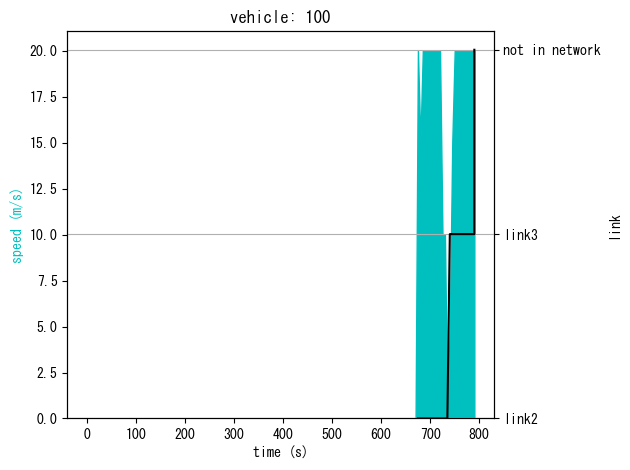

In [15]:
W.analyzer.plot_vehicle_log("100")

### GUI for interactive exploration

You can also launch GUI viewer for interactive exploration. It can play and pause network traffic animation, show time-space diagrams of selected links, and export CSVs.

In [ ]:
from uxsim.ResultGUIViewer import ResultGUIViewer
ResultGUIViewer.launch_World_viewer(W)

## Sioux Falls Network

An example with Sioux Falls network, a famous scenario for benchmarking in transportation research

In [17]:
# Simulation main
W = World(
    name="simple_demo",
    deltan=5,
    tmax=7200,
    print_mode=1, save_mode=1, show_mode=0,
    random_seed=0
)

# Scenario definition
#load CSV files
W.load_scenario_from_csv("dat/siouxfalls_nodes.csv", "dat/siouxfalls_links.csv", "dat/siouxfalls_demand.csv")

# Simulation execution
W.exec_simulation()

# Results analysis
W.analyzer.print_simple_stats()

simulation setting:
 scenario name: simple_demo
 simulation duration:	 7200 s
 number of vehicles:	 34690 veh
 total road length:	 314000.0 m
 time discret. width:	 5 s
 platoon size:		 5 veh
 number of timesteps:	 1440
 number of platoons:	 6938
 number of links:	 76
 number of nodes:	 24
 setup time:		 3.82 s
simulating...
      time| # of vehicles| ave speed| computation time
       0 s|        0 vehs|   0.0 m/s|     0.00 s
     600 s|     2550 vehs|   7.3 m/s|     1.51 s
    1200 s|     5825 vehs|   6.9 m/s|     3.39 s
    1800 s|     8695 vehs|   6.5 m/s|     5.49 s
    2400 s|    10285 vehs|   6.0 m/s|     7.71 s
    3000 s|    10930 vehs|   5.2 m/s|     9.89 s
    3600 s|    13380 vehs|   4.9 m/s|    11.95 s
    4200 s|    14330 vehs|   4.5 m/s|    14.03 s
    4800 s|    15155 vehs|   4.5 m/s|    15.99 s
    5400 s|    11065 vehs|   5.4 m/s|    17.50 s
    6000 s|     6625 vehs|   5.9 m/s|    18.49 s
    6600 s|     3370 vehs|   6.4 m/s|    19.08 s
    7195 s|     1390 vehs|   6

In [ ]:
from uxsim.ResultGUIViewer import ResultGUIViewer
ResultGUIViewer.launch_World_viewer(W)

 generating animation...


  0%|          | 0/180 [00:00<?, ?it/s]

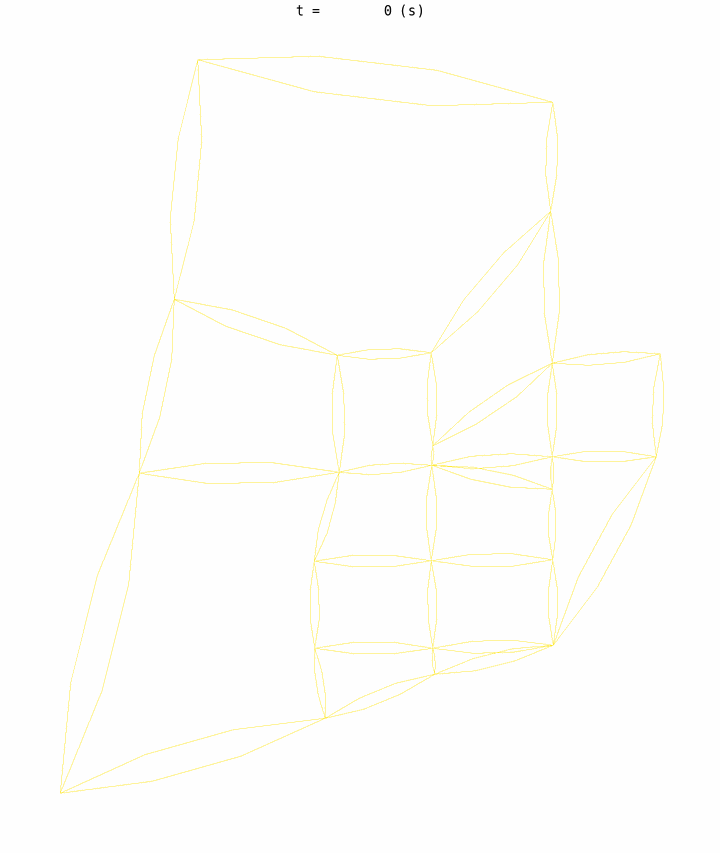

In [18]:
W.analyzer.network_anim(animation_speed_inverse=15, timestep_skip=8, detailed=0, network_font_size=0)
with open("outsimple_demo/anim_network0.gif", "rb") as f:
    display(Image(data=f.read(), format='png'))